In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prodzar/stocks-historical-price-data")

print("C:/Users/supre/Documents/FAI/PROJECT", path)

C:\Users\supre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:/Users/supre/Documents/FAI/PROJECT C:\Users\supre\.cache\kagglehub\datasets\prodzar\stocks-historical-price-data\versions\1


In [3]:
import pandas as pd
import os

# Path to your directory containing the CSV files
download_path = "C:/Users/supre/Documents/FAI/PROJECT/historical_data"
merged_data = pd.DataFrame()

# Loop through each file in the directory
for file in os.listdir(download_path):
    if file.endswith(".csv"):
        # Extract company name from the filename (without .csv extension)
        company_name = file.replace(".csv", "")
        
        # Load CSV into a DataFrame
        file_path = os.path.join(download_path, file)
        df = pd.read_csv(file_path)
        
        # Add a new column for the company name
        df["Company"] = company_name
        
        # Append to the merged DataFrame
        merged_data = pd.concat([merged_data, df], ignore_index=True)

# Save the merged DataFrame to a new CSV file
merged_data.to_csv("C:/Users/supre/Documents/FAI/PROJECT/merged_stocks_data.csv", index=False)

print("Data merged successfully into merged_stocks_data.csv.")


Data merged successfully into merged_stocks_data.csv.


In [12]:
merged_data.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
6456,2021-06-24,187.007043,187.653432,186.410364,187.563934,2876700,0.0,0.0,TXN
6457,2021-06-25,187.007044,189.194839,186.310929,187.126373,4639100,0.0,0.0,TXN
6458,2021-06-28,187.921928,191.313019,187.921928,190.467728,3228700,0.0,0.0,TXN
6459,2021-06-29,190.457799,191.939526,189.871060,191.810257,2108700,0.0,0.0,TXN
6460,2021-06-30,191.770458,191.929574,190.427954,191.233459,2687600,0.0,0.0,TXN


In [ ]:
merged_data['Company'].unique()

array(['AAPL', 'ADBE', 'AMZN', 'BTC-USD', 'FB', 'GCF', 'IRX', 'MSFT',
       'NVDA', 'QCOM', 'TSLA', 'TXN'], dtype=object)

In [16]:
import numpy as np
import pandas as pd
import random
from collections import deque
import matplotlib.pyplot as plt



In [ ]:
# Use your existing DataFrame
data = merged_data  # Assuming 'merged_data' is loaded

# Get unique companies
unique_companies = data['Company'].unique()

# Q-learning parameters
actions = ["Buy", "Sell", "Hold"]
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.995

# Initial portfolio
initial_balance = 10000
portfolio = {company: 0 for company in unique_companies}  # Shares held
balance = initial_balance

# Q-table
q_table = {}

def get_state(data, t):
    window = 5  # Use a rolling window of 5 days for context
    prices = data.iloc[max(0, t-window+1):t+1][["Open", "High", "Low", "Close", "Volume"]]
    return tuple(prices.values.flatten())

def get_reward(action, current_price, shares_held, balance, prev_value):
    # Calculate current portfolio value
    current_value = balance + shares_held * current_price
    reward = current_value - prev_value  # Reward is the change in value

    # Add bonuses for specific actions
    if action == "Sell" and shares_held > 0:
        reward += shares_held * current_price * 0.1  # Incentivize profitable selling
    elif action == "Buy" and balance >= current_price:
        reward += 0.05 * current_price  # Incentivize buying

    return reward, current_value

In [28]:
# Training loop
for episode in range(1, 101):  # Training for 100 episodes
    balance = initial_balance
    portfolio = {company: 0 for company in unique_companies}  # Shares held for each company
    prev_value = balance  # Initialize previous portfolio value
    total_reward = 0

    

    for t in range(len(merged_data) - 1):
        state = get_state(merged_data, t)
        company = merged_data.loc[t, "Company"]  # Get current company
        
        # Initialize Q-values for unseen states
        if state not in q_table:
            q_table[state] = [0] * len(actions)
        
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action_index = random.randint(0, len(actions) - 1)  # Explore
        else:
            action_index = np.argmax(q_table[state])  # Exploit

        action = actions[action_index]
        current_price = merged_data.loc[t, "Close"]
        shares_held = portfolio[company]  # Get shares held for the current company
        
        # Calculate reward and update prev_value
        reward, prev_value = get_reward(action, current_price, shares_held, balance, prev_value)

        # Update portfolio and balance
        if action == "Buy" and balance >= current_price:
            balance -= current_price
            portfolio[company] += 1
        elif action == "Sell" and shares_held > 0:
            balance += shares_held * current_price
            portfolio[company] = 0  # Sell all shares

        total_reward += reward

        # Next state
        next_state = get_state(merged_data, t + 1)

        # Q-learning update
        if next_state not in q_table:
            q_table[next_state] = [0] * len(actions)
        
        # Bellman equation
        old_q_value = q_table[state][action_index]
        next_max_q = max(q_table[next_state])
        q_table[state][action_index] = old_q_value + alpha * (reward + gamma * next_max_q - old_q_value)

    # Decay epsilon
    epsilon = max(epsilon * epsilon_decay, 0.01)


print("Training complete.")

Training complete.


In [30]:
# Calculate final portfolio values for each company and remaining cash
final_portfolio_value = {
    company: shares * merged_data[merged_data['Company'] == company].iloc[-1]['Close']
    for company, shares in portfolio.items()
}

# Add remaining cash to the portfolio
final_portfolio_value['Cash'] = balance

# Filter out zero-value holdings
final_portfolio_value = {k: v for k, v in final_portfolio_value.items() if v > 0}

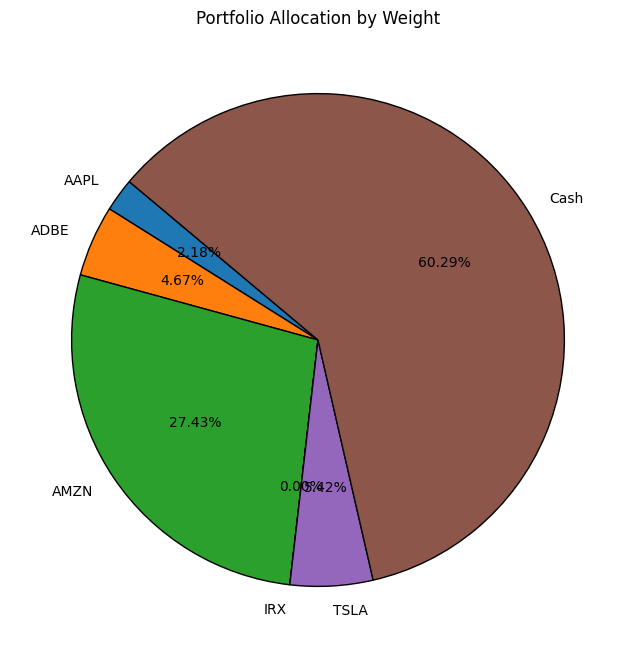

In [31]:
# Generate Pie Chart
labels = final_portfolio_value.keys()
sizes = final_portfolio_value.values()

plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.2f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Portfolio Allocation by Weight")
plt.show()

In [20]:
print(f"Action: {action}, Balance: {balance}, Shares: {portfolio}")

Action: Sell, Balance: 21930.42046964774, Shares: {'AAPL': 1, 'ADBE': 0, 'AMZN': 0, 'BTC-USD': 0, 'FB': 0, 'GCF': 0, 'IRX': 0, 'MSFT': 0, 'NVDA': 0, 'QCOM': 1, 'TSLA': 0, 'TXN': 0}


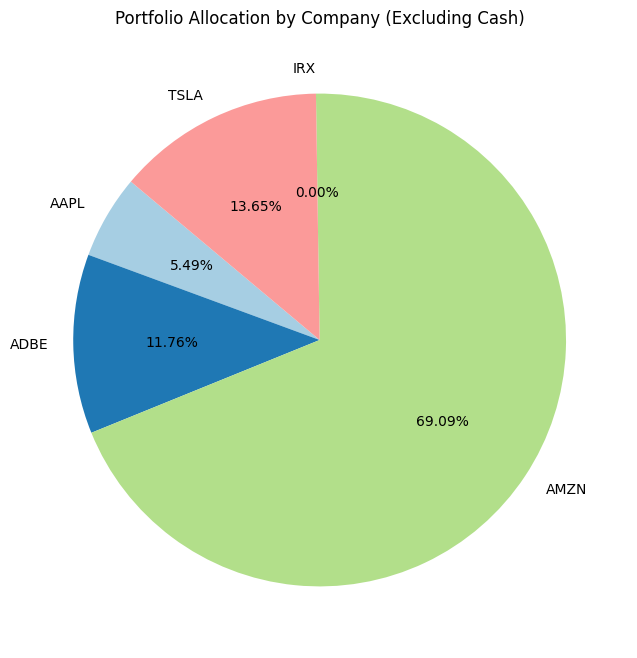

In [32]:
import matplotlib.pyplot as plt

# Assuming you have a 'portfolio' dictionary with companies and their shares
# and the 'merged_data' DataFrame has the necessary data to calculate the final values.

# Calculate final portfolio values for each company (excluding cash)
final_portfolio_value = {
    company: shares * merged_data[merged_data['Company'] == company].iloc[-1]['Close']
    for company, shares in portfolio.items() if shares > 0  # Exclude companies with no shares
}

# Remove companies with zero value (if any)
final_portfolio_value = {company: value for company, value in final_portfolio_value.items() if value > 0}

# Prepare the data for the pie chart (values and labels)
labels = list(final_portfolio_value.keys())
values = list(final_portfolio_value.values())

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(values, labels=labels, autopct='%1.2f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Portfolio Allocation by Company (Excluding Cash)")
plt.show()
